## The modified SEIR model

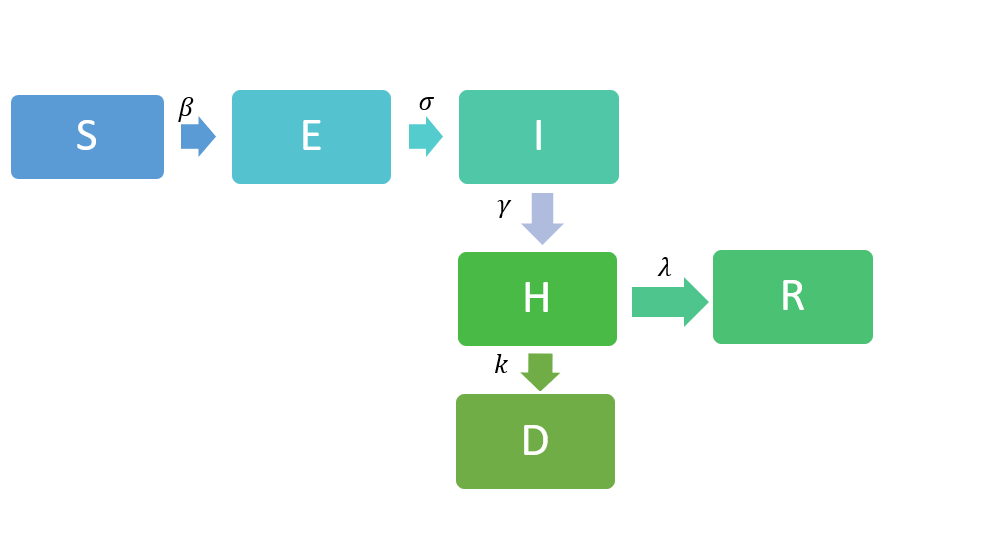
In this modified SEIR model, we have __6__ compartments: __S(susceptible)__, __E(exposed)__, __I(infectious)__, __R(recovered)__, __H(hospitalized)__, __D(dead)__.<br>
Our model is given by:<br>
\begin{equation}
S(t+1) = S(t) - \frac{\beta_{1} \times r \times I(t) \times S(t)}{M(t)} - \frac{\beta_{2} \times r \times E(t) \times S(t)}{M(t)}\\
E(t+1) = E(t) + \frac{\beta_{1} \times r \times I(t) \times S(t)}{M(t)} + \frac{\beta_{2} \times r \times E(t) \times S(t)}{M(t)} - \sigma \times E(t)\\
I(t+1) = I(t) + \sigma \times E(t) - \gamma \times I(t)\\
H(t+1) = H(t) + \gamma \times I(t) -\lambda \times H(t) - k \times H(t)\\
R(t+1) = R(t) + \lambda \times H(t)\\
D(t+1) = D(t) + k \times H(t)
\end{equation}

$S(t)$: The number of susceptible people in a country or region.<br>
$\beta_{1}$: The rate of transmission for the susceptible to infected.<br>
$\beta_{2}$: The rate of transmission for the susceptible to exposed.<br>
$r$: The contact ratey, related to control policies.<br>
$M(t)$: The total population in a country or region.<br>
$E(t)$: The number of exposed people in a country or region.<br>
$\sigma$: The incubation rate.<br>
$I(t)$: The number of infected people in a country or region.<br>
$\gamma$: The hospitalization rate.<br>
$H(t)$: The number of hospitalized people in a country or region.<br>
$\lambda$: The recovery rate.<br>
$R(t)$: The number of recovered people in a country or region.<br>
$k$: The mortality rate by covid-19.<br>
$D(t)$: The number of dead people by the virus in a country or region.<br>


## Model Parameters Estimation  

In [1]:
using HTTP, DataFrames, CSV, Query, Dates
urlPrefix = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/"
global_confirmedFile =  "time_series_covid19_confirmed_global.csv"
global_deathsFile = "time_series_covid19_deaths_global.csv"
global_recoveredFile = "time_series_covid19_recovered_global.csv"

# function used to make the raw data as a dataframe
makeDF(url) = CSV.read(IOBuffer(String((HTTP.get(url)).body)));

# load the global confirmed/deaths/recovered cases data 
global_confirmedDF = makeDF(urlPrefix*global_confirmedFile);
global_deathsDF = makeDF(urlPrefix*global_deathsFile);
global_recoveredDF = makeDF(urlPrefix*global_recoveredFile);

# function used to get Province/State, Country/Region these two column renamed
function cleanNames(df)
    rename!(df,Symbol("Province/State")=>:ProvinceOrState)
    rename!(df,Symbol("Country/Region")=>:CountryOrRegion)
    
end

# use the cleanNames() function to get Province/State, Country/Region in each dataframe renamed
cleanNames(global_confirmedDF)
cleanNames(global_deathsDF)
cleanNames(global_recoveredDF)

#This function can be used for country data
#type is :confirmed, :deaths or :recovered
function countryData(countryName,dfType; sumProvinces = true)
    if dfType == :confirmed
        df = global_confirmedDF
    elseif dfType == :deaths
        df = global_deathsDF
    elseif dfType == :recovered
        df = global_recoveredDF
    else
        println("error")
    end
    # group the dataframe by CountryOrRegion
    df = groupby(df,:CountryOrRegion; sort=false, skipmissing=false);
    df = combine(df, names(df)[Not(1:4)] .=> sum);
    CountryData = df[df.CountryOrRegion .== countryName, :];
    if sumProvinces
        CountryData = DataFrames.stack(CountryData, names(CountryData))[2:end,:];
        CountryData[:1] = string.(collect(CountryData[:1]));
        CountryData[:2] = Int.(collect(CountryData[:2]));
        return CountryData
    else 
        return CountryData
    end
end

        
function cleanDate(df,dfType)
    i = 1;
    dateArray = Date.([]);
    for date in df[:,:1]
        m, d, y = split(date,"/");
        push!(dateArray,Dates.Date(parse(Int64,"20"*(y[1:2])),parse(Int64,m),parse(Int64,d)));
        i += 1;
    end
    df[:1] = dateArray;
    if dfType == :confirmed
        names!(df, [:date, :total_confirmed]);
    elseif dfType == :deaths
        names!(df, [:date, :total_deaths]);
    elseif dfType == :recovered
        names!(df, [:date, :total_recovered]);
    else
        println("error")
    end
    return df
end

cleanDate (generic function with 1 method)

In order to apply the modified SEIR model above, we need to estimate the parameters $\beta$, $\sigma$, $\gamma$, $\lambda$ and $k$, where $\beta$ is the product of the people exposed to each day by infected people ($n$) and the probability of transmission ($b$) when exposed (i.e.,$\beta= nb$) and $\sigma$ is the incubation rate which is the rate of latent
individuals becoming symptomatic (average duration of incubation is $\frac{1}{\sigma}$). According to the information from WHO, the incubation period for COVID-19 is on average 5-6 days. Therefore, I decided to choose the midpoint of 5.5 days. $\gamma$ is the average rate of hospitalization which is about 0.22. $\lambda$ is the average rate of recovery in hospitalized(infected) populations, and $k$ is the average mortality rate caused by covid-19. Using epidemic data from some selected countries, I modeled the skewed SEIR model to determine the probability of transmission (b) which was used to derive $\beta$, $\lambda$ and $k$.<br>

With $I(t=0)=1$, which is available early in the outbreak, N≈S and therefore approximates$\frac{dI}{dt} = \beta \frac{IS}{M} - \lambda I \approx (\beta - \lambda)I$. It is easy to know that the general solution of the differential equation is $I(t) = Ce^{(\beta-\lambda)t}$. Since $I(t=0) = 1$, we can get $C = 1 \Longrightarrow I(t) = e^{(\beta-\lambda)t}$. 

Now, our objective function is $$\mathbf{min}\sum_{t\in T}^{} (e^{(\beta-\lambda)t} - \hat{I}(t))^{2}$$, where $\hat{I}(t)$ is the actual number of confirmed cases.

###  $\beta_1$, $\beta_2$ and $\lambda$ in U.S. 

In [22]:
usa_cumulative_confirmed = cleanDate(countryData("US",:confirmed; sumProvinces = true),:confirmed);

Since the first case of covid-19 was confirmed on the __2020-01-22__ in the US, I added a column named timeRange which used to store the difference between the date of current row and __2020-01-22__.

In [24]:
usa_cumulative_confirmed[:timeRange] = Dates.value.(usa_cumulative_confirmed[:1] - Dates.Date(2020,1,22));
usa_cumulative_confirmed

,date,total_confirmed,timeRange
,Date,Int64,Int64
1,2020-01-22,1,0
2,2020-01-23,1,1
3,2020-01-24,2,2
4,2020-01-25,2,3
5,2020-01-26,5,4
6,2020-01-27,5,5
7,2020-01-28,5,6
8,2020-01-29,6,7
9,2020-01-30,6,8


The table above inclueds the data of cumulative confirmed cases in the US from __2020-01-22__ till today. It is obvious that the data beore __2020-02-29__ may be not accurate, so I decided to select the data from __2020-02-29 to 2020-03-09__ to identify the probability of infection $b$.<br>

As the US epidemic prevention and control measures are not strict during this period, we can assume that the contact rate is around __10__.

In [25]:
using Optim;




# select the data from 2020-02-29 to 2020-03-09 
ten_day_confirmed_usa = usa_cumulative_confirmed[(usa_cumulative_confirmed.date .<= Dates.Date(2020,3,9)) .& 
    (usa_cumulative_confirmed.date .>= Dates.Date(2020,2,29)),:];

# contact rate of U.S. between 2020-02-29 and 2020-03-09
nContact = 10;

# the cost function
f(x) = sum((exp.((x[1]*nContact - x[2])*ten_day_confirmed_usa.timeRange) - ten_day_confirmed_usa.total_confirmed).^2)/(size(ten_day_confirmed_usa.timeRange)[1])

# starting point
x0 = [0.04, 0.1]

# optimize the cost function
results = optimize(f, x0, NelderMead());

# print the optimization results
println("The probability of transmission of U.S.: ", Optim.minimizer(results)[1])
println("The recovery rate of U.S.: ", Optim.minimizer(results)[2])

The probability of transmission of U.S.: 0.027559709345011184
The recovery rate of U.S.: 0.14585997990482513


I assume that a symptomatic, infectious $I$ will be quarantined, therefore the people exposed to each day by $n_1 = 3$ infected people.<br>
I assume that an asymptomatic, lantent $E$ will have normal contact, therefore the people exposed to each day by $n_1 = 15$ lantent people.
Therefore, $$\beta_{us_{1}} = n_1 \beta_{us} = 3 \times 0.02753 = 0.08259$$ $$\beta_{us_{2}} = n_2 \beta_{us} = 15 \times 0.02753 = 0.41295$$
$$\lambda_{us} = 0.14565$$

###  $\beta_1$, $\beta_2$ and $\lambda$ in China 

In [27]:
# get the chinese cumulative confirmed cases from 1/22/20 - today
china_cumulative_confirmed = cleanDate(countryData("China",:confirmed; sumProvinces = true),:confirmed);

Since the first case of covid-19 was confirmed on the __2010-12-08__ in China, I added a column named timeRange which used to store the difference between the date of current row and __2010-12-08__.

In [28]:
china_cumulative_confirmed[:timeRange] = Dates.value.(china_cumulative_confirmed[:1] - Dates.Date(2019,12,8));
china_cumulative_confirmed

,date,total_confirmed,timeRange
,Date,Int64,Int64
1,2020-01-22,548,45
2,2020-01-23,643,46
3,2020-01-24,920,47
4,2020-01-25,1406,48
5,2020-01-26,2075,49
6,2020-01-27,2877,50
7,2020-01-28,5509,51
8,2020-01-29,6087,52
9,2020-01-30,8141,53


The table above inclueds the data of cumulative confirmed cases in China from __2020-01-22__ till today. I decided to select the data from __2020-01-22 to 2020-01-31__ to identify the probability of infection $b$.<br>

As the epidemic prevention and control measures in China are strict during this period, we can assume that the contact rate is around __3__.

In [29]:
# select the data from 2020-01-22 to 2020-01-31 
ten_day_confirmed_china = china_cumulative_confirmed[(china_cumulative_confirmed.date .<= Dates.Date(2020,1,31)) .& 
    (china_cumulative_confirmed.date .>= Dates.Date(2020,1,22)),:];

# contact rate of China between 2020-01-22 and 2020-01-31
nContact = 5;

# the cost function
f(y) = sum((exp.((y[1]*nContact - y[2])*ten_day_confirmed_china.timeRange) - ten_day_confirmed_china.total_confirmed).^2)/(size(ten_day_confirmed_china.timeRange)[1])

# starting point
y0 = [0.04, 0.1]

# optimize the cost function
results = optimize(f, y0, NelderMead());

# print the optimization results
println("The probability of transmission of China: ", Optim.minimizer(results)[1])
println("The recovery rate of China: ", Optim.minimizer(results)[2])

The probability of transmission of China: 0.05266938493049029
The recovery rate of China: 0.09624509072236229


I assume that a symptomatic, infectious $I$ will be quarantined, therefore the people exposed to each day by $n_1 = 3$ infected people.<br>
I assume that an asymptomatic, lantent $E$ will have normal contact, therefore the people exposed to each day by $n_1 = 15$ lantent people.
Therefore, $$\beta_{cn_{1}} = n_1 \beta_{cn} = 3 \times 0.05267 = 0.15801$$ $$\beta_{cn_{2}} = n_2 \beta_{cn} = 15 \times 0.05267 = 0.7901$$ 
$$\lambda_{cn} = 0.09625$$

###  $\beta_1$, $\beta_2$ and $\lambda$ in Australia 

In [31]:
# get australian cumulative confirmed cases from 1/22/20 - today
australia_cumulative_confirmed = cleanDate(countryData("Australia",:confirmed; sumProvinces = true),:confirmed);

Since the first case of covid-19 was confirmed on the __2010-1-26__ in Australia, I added a column named timeRange which used to store the difference between the date of current row and __2010-1-26__.

In [32]:
australia_cumulative_confirmed[:timeRange] = Dates.value.(australia_cumulative_confirmed[:1] - Dates.Date(2020,1,26))
australia_cumulative_confirmed

,date,total_confirmed,timeRange
,Date,Int64,Int64
1,2020-01-22,0,-4
2,2020-01-23,0,-3
3,2020-01-24,0,-2
4,2020-01-25,0,-1
5,2020-01-26,4,0
6,2020-01-27,5,1
7,2020-01-28,5,2
8,2020-01-29,6,3
9,2020-01-30,9,4


The table above inclueds the data of cumulative confirmed cases in Australia from __2020-01-22__ till today. It is obvious that the data beore 2020-03-03 may be not accurate, so I decided to select the data from __2020-03-03 to 2020-03-12__ to identify the probability of infection $b$.<br>

As the Australia border has been closed on __2020-03-20__, and epidemic control measure like social distancing are not too strict, we can assume that the contact rate is around 10 during these period.

In [33]:
# select the data from 2020-03-03 to 2020-03-12
ten_day_confirmed_australia = australia_cumulative_confirmed[(australia_cumulative_confirmed.date .<= Dates.Date(2020,3,12)) .& 
    (australia_cumulative_confirmed.date .>= Dates.Date(2020,3,3)),:];

# contact rate of Australia between 2020-03-03 and 2020-03-12
nContact = 10;

# the cost function
f(z) = sum((exp.((z[1]*nContact - z[2])*ten_day_confirmed_australia.timeRange) - ten_day_confirmed_australia.total_confirmed).^2)/(size(ten_day_confirmed_australia.timeRange)[1])

# starting point
z0 = [0.04, 0.1]

# optimize the cost function
results = optimize(f, z0, NelderMead());

# print the optimization results
println("The probability of transmission of Australia: ", Optim.minimizer(results)[1])
println("The recovery rate of Australia: ", Optim.minimizer(results)[2])

The probability of transmission of Australia: 0.020395941287722034
The recovery rate of Australia: 0.09888480580169849


I assume that a symptomatic, infectious $I$ will be quarantined, therefore the people exposed to each day by $n_1 = 3$ infected people.<br>
I assume that an asymptomatic, lantent $E$ will have normal contact, therefore the people exposed to each day by $n_1 = 15$ lantent people.
Therefore, $$\beta_{au_{1}} = n_1 \beta_{au} = 3 \times 0.02040 = 0.06120$$ $$\beta_{au_{2}} = n_2 \beta_{au} = 15 \times 0.02040 = 0.30600$$
$$\lambda_{au} = 0.09888$$

## Case Fatality Rate ($k$) Estimation 

At this part, I will estimate the case fatality ratio (CFR). Case fatality ratio (CFR) is the proportion of individuals diagnosed with a disease who die from that disease and is therefore a measure of severity among detected cases:
$$CFR(\mbox{in %}) = \frac{\mbox{Number of deaths from disease}}{\mbox{Number of confirmed cases from disease}}\times 100$$
It makes two assumptions:<br>
__Assumption 1: The likelihood of detecting cases and deaths is consistent over the course of the outbreak.__<br>
__Assumption 2: All detected cases have resolved (that is, reported cases have either recovered or died).__

In [34]:
usa_cumulative_deaths = cleanDate(countryData("US",:deaths; sumProvinces = true),:deaths);

usa_dailyCFR = usa_cumulative_deaths.total_deaths ./ usa_cumulative_confirmed.total_confirmed;
usa_meanCFR = sum([if isnan(i)==1; 0 else i end for i in usa_dailyCFR])/(length(usa_dailyCFR));
println("The case fatality rate of U.S.: ", usa_meanCFR)

The case fatality rate of U.S.: 0.03655757193584609


$k_{us} = 0.03656$

In [35]:
china_cumulative_deaths = cleanDate(countryData("China",:deaths; sumProvinces = true),:deaths);

china_dailyCFR = china_cumulative_deaths.total_deaths ./ china_cumulative_confirmed.total_confirmed
china_meanCFR = sum([if isnan(i)==1; 0 else i end for i in china_dailyCFR])/length(china_dailyCFR)
println("The case fatality rate of China: ", china_meanCFR)

The case fatality rate of China: 0.04715678433547855


$k_{cn} = 0.04716$

In [36]:
australia_cumulative_deaths = cleanDate(countryData("Australia",:deaths; sumProvinces = true),:deaths);

australia_dailyCFR = australia_cumulative_deaths.total_deaths ./ australia_cumulative_confirmed.total_confirmed
australia_meanCFR = sum([if isnan(i)==1; 0 else i end for i in australia_dailyCFR])/length(australia_dailyCFR)
println("The case fatality rate of Australia: ", australia_meanCFR)

The case fatality rate of Australia: 0.013925305037329777


$k_{au} = 0.01393$

## Model Simulation
Firstly, I tried to use DoobGillespie algorithm (refer to Yoni's book),The detail is shown below.

#### 1. DoobGillespie algorithm

In [37]:
using Distributions, Random, Plots;
Random.seed!(0);

In [38]:
# the function that implements DoobGillespie simulation
function moderatedSEIRDoobGillespie(beta_1,beta_2,r,sigma,gamma,lambda,k,T,M,I0)
    # set the inital value 
    t, S, E, I, H, R, D = 0.0, M-I0, 0, I0, 0, 0, 0
    # initialize results list
    tValues, sValues, eValues, iValues, hValues, rValues, dValues= [t], [S], [E], [I], [H], [R], [D]
    # main loop
    while t<T 
        exposedRate = beta_1*r*I*S/M + beta_2*r*E*S/M 
        infectionRate = sigma*E 
        hospitalizationRate = gamma*I
        deathRate = k*H
        recoveredRate = lambda*H 
    
        totalRate = exposedRate + infectionRate + hospitalizationRate + deathRate + recoveredRate  
        probs = [exposedRate,infectionRate,hospitalizationRate,deathRate,recoveredRate]/totalRate
        
        # generate exponentially distributed random variable t
        t += rand(Exponential(1/(totalRate)))
        u = rand()
        #println(u)
        #println(probs)
       
        if 0 < u < probs[1] 
            S -= 1; E += 1
        elseif 0 + probs[1] < u < 0 + probs[1] + probs[2]
            E -=1; I += 1
        elseif 0 + probs[1] + probs[2]< u < 0 + probs[1] + probs[2] + probs[3]
            I -= 1; H += 1
        elseif 0 + probs[1] + probs[2] + probs[3] < u
            if 0 + probs[1] + probs[2] + probs[3] < u < 0 + probs[1] + probs[2] + probs[3] + probs[4] 
                H -= 1; D += 1 
            elseif 0 + probs[1] + probs[2] + probs[3] + probs[4] < u < 0 + probs[1] + probs[2] + probs[3] + probs[5] 
                H -= 1; R += 1
            end
         end
        push!(tValues,t);
        push!(sValues,S);
        push!(eValues,E);
        push!(iValues,I);
        push!(rValues,R);
        push!(hValues,H);
        push!(dValues,D);
        I == 0  && break
    end
    return [tValues, sValues, eValues, iValues, rValues, hValues, dValues]
end

moderatedSEIRDoobGillespie (generic function with 1 method)

## U.S. epedemic model simulation 

In [39]:
# the values of all parameters

# the rate of transmission for the susceptible to infected 
beta_1 = 0.08259;

# the rate of transmission for the susceptible to exposed 
beta_2 = 0.41295;

# the contact rate
r = 10.0;

# the incubation rate
sigma = 1/5.5;

# the hospitalization rate 
gamma = 0.22;

# the recovery rate (from hospitalized to recovered)
lambda =0.14565;

# The mortality rate by covid-19
k =0.03656;

# the inital infected percentage and the total population (S+E+I+H+R+D).
initialInfect, M = 0.025, 1000;

# the inital infected population
I0 = Int(floor(initialInfect*M));

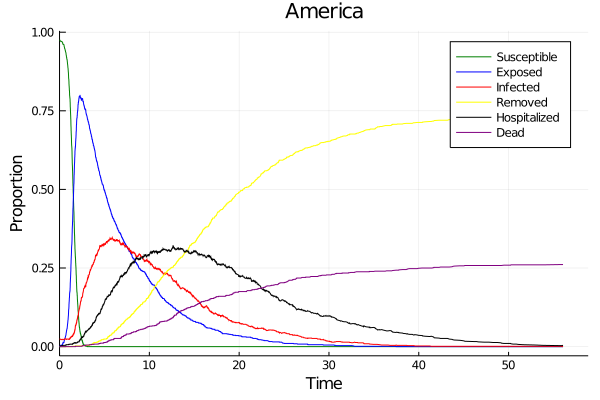

In [40]:
tV,sV,eV,iV,rV,hV, dV = moderatedSEIRDoobGillespie(beta_1,beta_2,r,sigma,gamma,lambda,k,Inf,M,I0);
p3 = Plots.plot(tV,sV/M,label = "Susceptible", c=:green)
Plots.plot!(tV,eV/M,label = "Exposed", c=:blue)
Plots.plot!(tV,iV/M,label = "Infected",c=:red)
Plots.plot!(tV,rV/M,label = "Removed",c=:yellow)
Plots.plot!(tV,hV/M,label = "Hospitalized", c=:black)
Plots.plot!(tV,dV/M,label = "Dead", c=:purple,
    title = "America",
    xlabel = "Time", ylabel = "Proportion",
    legend = :topright, xlim = (0,tV[end]*1.05))

## Austrlian epedemic model simulation

In [41]:
# the values of all parameters

# the rate of transmission for the susceptible to infected 
beta_1 = 0.06120;

# the rate of transmission for the susceptible to exposed 
beta_2 = 0.30600;

# the contact rate
r = 10.0;

# the incubation rate
sigma = 1/5.5;

# the hospitalization rate 
gamma = 0.22;

# the recovery rate (from hospitalized to recovered)
lambda = 0.09888;

# The mortality rate by covid-19
k = 0.01393;

# the inital infected percentage and the total population (S+E+I+H+R+D).
initialInfect, M = 0.025, 1000;

# the inital infected population
I0 = Int(floor(initialInfect*M));

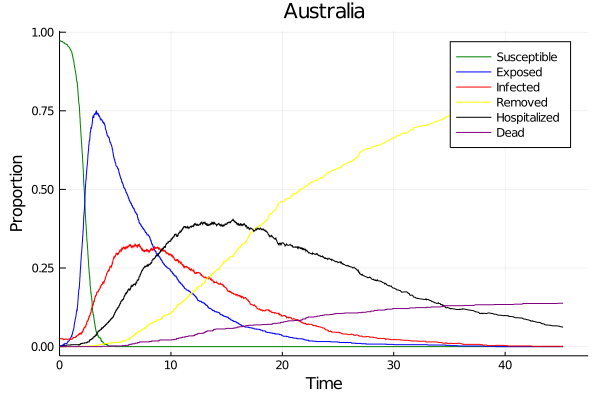

In [42]:
tV,sV,eV,iV,rV,hV, dV = moderatedSEIRDoobGillespie(beta_1,beta_2,r,sigma,gamma,lambda,k,Inf,M,I0);
p3 = Plots.plot(tV,sV/M,label = "Susceptible", c=:green)
Plots.plot!(tV,eV/M,label = "Exposed", c=:blue)
Plots.plot!(tV,iV/M,label = "Infected",c=:red)
Plots.plot!(tV,rV/M,label = "Removed",c=:yellow)
Plots.plot!(tV,hV/M,label = "Hospitalized", c=:black)
Plots.plot!(tV,dV/M,label = "Dead", c=:purple,
    title = "Australia",
    xlabel = "Time", ylabel = "Proportion",
    legend = :topright, xlim = (0,tV[end]*1.05))

## Chinese epedemic model simulation

In [43]:
# the values of all parameters

# the rate of transmission for the susceptible to infected 
beta_1 = 0.15801;

# the rate of transmission for the susceptible to exposed 
beta_2 = 0.7901;

# the contact rate
r = 10.0;

# the incubation rate
sigma = 1/5.5;

# the hospitalization rate 
gamma = 0.22;

# the recovery rate (from hospitalized to recovered)
lambda = 0.09625;

# The mortality rate by covid-19
k = 0.04716;

# the inital infected percentage and the total population (S+E+I+H+R+D).
initialInfect, M = 0.025, 1000;

# the inital infected population
I0 = Int(floor(initialInfect*M));

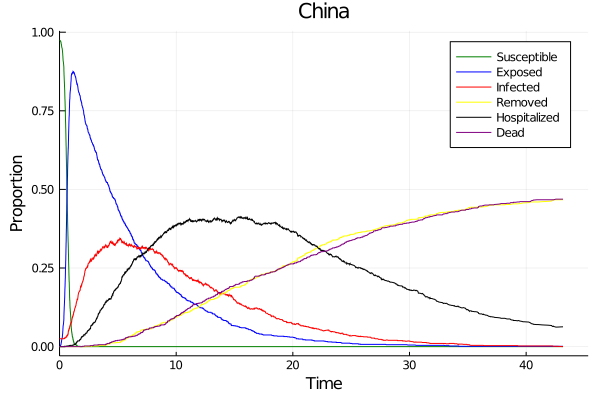

In [44]:
tV,sV,eV,iV,rV,hV, dV = moderatedSEIRDoobGillespie(beta_1,beta_2,r,sigma,gamma,lambda,k,Inf,M,I0);
p3 = Plots.plot(tV,sV/M,label = "Susceptible", c=:green)
Plots.plot!(tV,eV/M,label = "Exposed", c=:blue)
Plots.plot!(tV,iV/M,label = "Infected",c=:red)
Plots.plot!(tV,rV/M,label = "Removed",c=:yellow)
Plots.plot!(tV,hV/M,label = "Hospitalized", c=:black)
Plots.plot!(tV,dV/M,label = "Dead", c=:purple,
    title = "China",
    xlabel = "Time", ylabel = "Proportion",
    legend = :topright, xlim = (0,tV[end]*1.05))